In [7]:
import os 

os.chdir("/home/iustin/SimpleNet_Pytorch/cifar")
os.getcwd()

'/home/iustin/SimpleNet_Pytorch/cifar'

In [8]:
import models

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [9]:
from models.simplenet import simplenet_cifar_5m

model = models.__dict__['simplenet_cifar_5m'](num_classes = 10, in_chans = 3)

In [10]:
from torchinfo import summary

summary(model, 
        input_size=(1, 3, 32, 32), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 3, 32, 32]       [1, 10]              --                   True
├─Sequential (features)                  [1, 3, 32, 32]       [1, 256, 2, 2]       --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 64, 32, 32]      1,792                True
│    └─BatchNorm2d (1)                   [1, 64, 32, 32]      [1, 64, 32, 32]      128                  True
│    └─ReLU (2)                          [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
│    └─Dropout2d (3)                     [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
│    └─Conv2d (4)                        [1, 64, 32, 32]      [1, 128, 32, 32]     73,856               True
│    └─BatchNorm2d (5)                   [1, 128, 32, 32]     [1, 128, 32, 32]     256                  True
│    └─ReLU (6)   

In [11]:
os.getcwd()

'/home/iustin/SimpleNet_Pytorch/cifar'

In [12]:
import sys

# Add the directory to the Python path in this notebook 
sys.path.append('/home/iustin/SimpleNet_Pytorch/cifar')

In [13]:
import utils 
from CIFAR10 import CIFAR10

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the mean and std transformation for the image
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

train_transform = transforms.Compose(
[ transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize(mean, std)])
#[transforms.CenterCrop(32), transforms.ToTensor(),
# transforms.Normalize(mean, std)])
    #)
test_transform = transforms.Compose(
[transforms.CenterCrop(32), transforms.ToTensor(), transforms.Normalize(mean, std)])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Find a dog image
dog_label = classes.index('dog')  # Get the index/label for 'dog'

# Modified function to save an image
def save_image(img, filename='sample_dog.png'):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(filename)  # Save the image to a file

# Use the save_image function instead of imshow in the loop
for images, labels in trainloader:
    if labels[0] == dog_label:
        save_image(images[0], 'sample_dog.png')
        print('Label:', classes[labels[0]])
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog


In [ ]:
parent_dir = 'samples'

# Ensure the parent directory exists
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)
    
# Initialize a dictionary to keep count of saved images per class
saved_images_count = {classname: 0 for classname in classes}

# Dictionary to store two images per class
images_to_save = {classname: [] for classname in classes}

# Loop through the dataset to find and save two images of each class
for images, labels in trainloader:
    for image, label in zip(images, labels):
        classname = classes[label]
        if saved_images_count[classname] < 2:
            # Save the image to the corresponding class list
            images_to_save[classname].append(image)
            saved_images_count[classname] += 1
            # Check if we have collected two images for each class
            if all(count == 2 for count in saved_images_count.values()):
                break
    if all(count == 2 for count in saved_images_count.values()):
        break

# Loop through each class and save images in respective folders
for classname, images in images_to_save.items():
    # Create a directory for the current class if it doesn't exist
    class_dir = os.path.join(parent_dir, classname)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    
    # Save each image in the class directory
    for idx, image in enumerate(images):
        filename = os.path.join(class_dir, f'sample_{classname}_{idx+1}.png')
        save_image(image, filename)
        print(f'Saved {filename}')

In [ ]:
os.getcwd()

[Older implementation of simplenet](https://github.com/Coderx7/SimpleNet_Pytorch/blob/5d13ddbba6ae531ced26469c6b0f0ec18665d5ec/models/simplenet.py) that mitigates the error of nn.DataParallel mismatch when loading the checkpoint. Also Coderx7's [response for my issue](https://github.com/Coderx7/SimpleNet_Pytorch/issues/7), that suggested removing extra dropout layers after all layers.

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class simplenet(nn.Module):
    def __init__(self, classes=10, simpnet_name='simplenet'):
        super(simplenet, self).__init__()
        #print(simpnet_name)
        self.features = self._make_layers() #self._make_layers(cfg[simpnet_name])
        self.classifier = nn.Linear(256, classes)
        self.drp = nn.Dropout(0.1)

    def load_my_state_dict(self, state_dict):

        own_state = self.state_dict()

        # print(own_state.keys())
        # for name, val in own_state:
        # print(name)
        for name, param in state_dict.items():
            name = name.replace('module.', '')
            if name not in own_state:
                # print(name)
                continue
            if isinstance(param, Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            print("STATE_DICT: {}".format(name))
            try:
                own_state[name].copy_(param)
            except:
                print('While copying the parameter named {}, whose dimensions in the model are'
                      ' {} and whose dimensions in the checkpoint are {}, ... Using Initial Params'.format(
                    name, own_state[name].size(), param.size()))

    def forward(self, x):
        out = self.features(x)

        #Global Max Pooling
        out = F.max_pool2d(out, kernel_size=out.size()[2:]) 
        # out = F.dropout2d(out, 0.1, training=True)
        out = self.drp(out)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):

        model = nn.Sequential(
                             nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                             nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),



                             nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),



                             nn.Conv2d(2048, 256, kernel_size=[1, 1], stride=(1, 1), padding=(0, 0)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),


                             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
                             nn.Dropout2d(p=0.1),


                             nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
                             nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
                             nn.ReLU(inplace=True),

                            )

        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

        return model
    
model = simplenet(classes=10, simpnet_name='simplenet')

def remove_dropout_layers(model):
    features = torch.nn.Sequential()
    prev_layer = None
    i=0
    for layer in model.features.children():
        if isinstance(layer, torch.nn.Dropout2d):
            if not isinstance(prev_layer, torch.nn.MaxPool2d):
                continue
            layer = torch.nn.Dropout2d(0.1)
        prev_layer = layer
        features.add_module(str(i), layer);i+=1
    # assign the updated features
    model.features = features
    return model

checkpoint = torch.load("snapshots/simplenetv1/CIFAR10/95.51/best_chkpt_simplenet_cifar10_2018-12-25_00-34-57.pth.tar")
# remove the "module." prefix
state_dict = checkpoint['state_dict']
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove the extra dropouts 
model = remove_dropout_layers(model)
# load the new state_dict into the model
model.load_state_dict(state_dict)

from torchinfo import summary 

summary(model,
        input_size=(1, 3, 32, 32),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
simplenet (simplenet)                    [1, 3, 32, 32]       [1, 10]              --                   True
├─Sequential (features)                  [1, 3, 32, 32]       [1, 256, 1, 1]       --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 64, 32, 32]      1,792                True
│    └─BatchNorm2d (1)                   [1, 64, 32, 32]      [1, 64, 32, 32]      128                  True
│    └─ReLU (2)                          [1, 64, 32, 32]      [1, 64, 32, 32]      --                   --
│    └─Conv2d (3)                        [1, 64, 32, 32]      [1, 128, 32, 32]     73,856               True
│    └─BatchNorm2d (4)                   [1, 128, 32, 32]     [1, 128, 32, 32]     256                  True
│    └─ReLU (5)                          [1, 128, 32, 32]     [1, 128, 32, 32]     --                   --
│    └─Conv2d (6) 

In [60]:
from models.simplenet import simplenet_cifar_5m_extra_pool

model2 = models.__dict__['simplenet_cifar_5m_extra_pool'](num_classes = 10, in_chans = 3)

checkpoint = torch.load("snapshots/simplenetv1/CIFAR10/95.51/best_chkpt_simplenet_cifar10_2018-12-25_00-34-57.pth.tar")
# remove the "module." prefix
state_dict = checkpoint['state_dict']
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove the extra dropouts 
model2 = remove_dropout_layers(model2)
# load the new state_dict into the model
model2.load_state_dict(state_dict)

<All keys matched successfully>

Number of misclassified images collected: 458


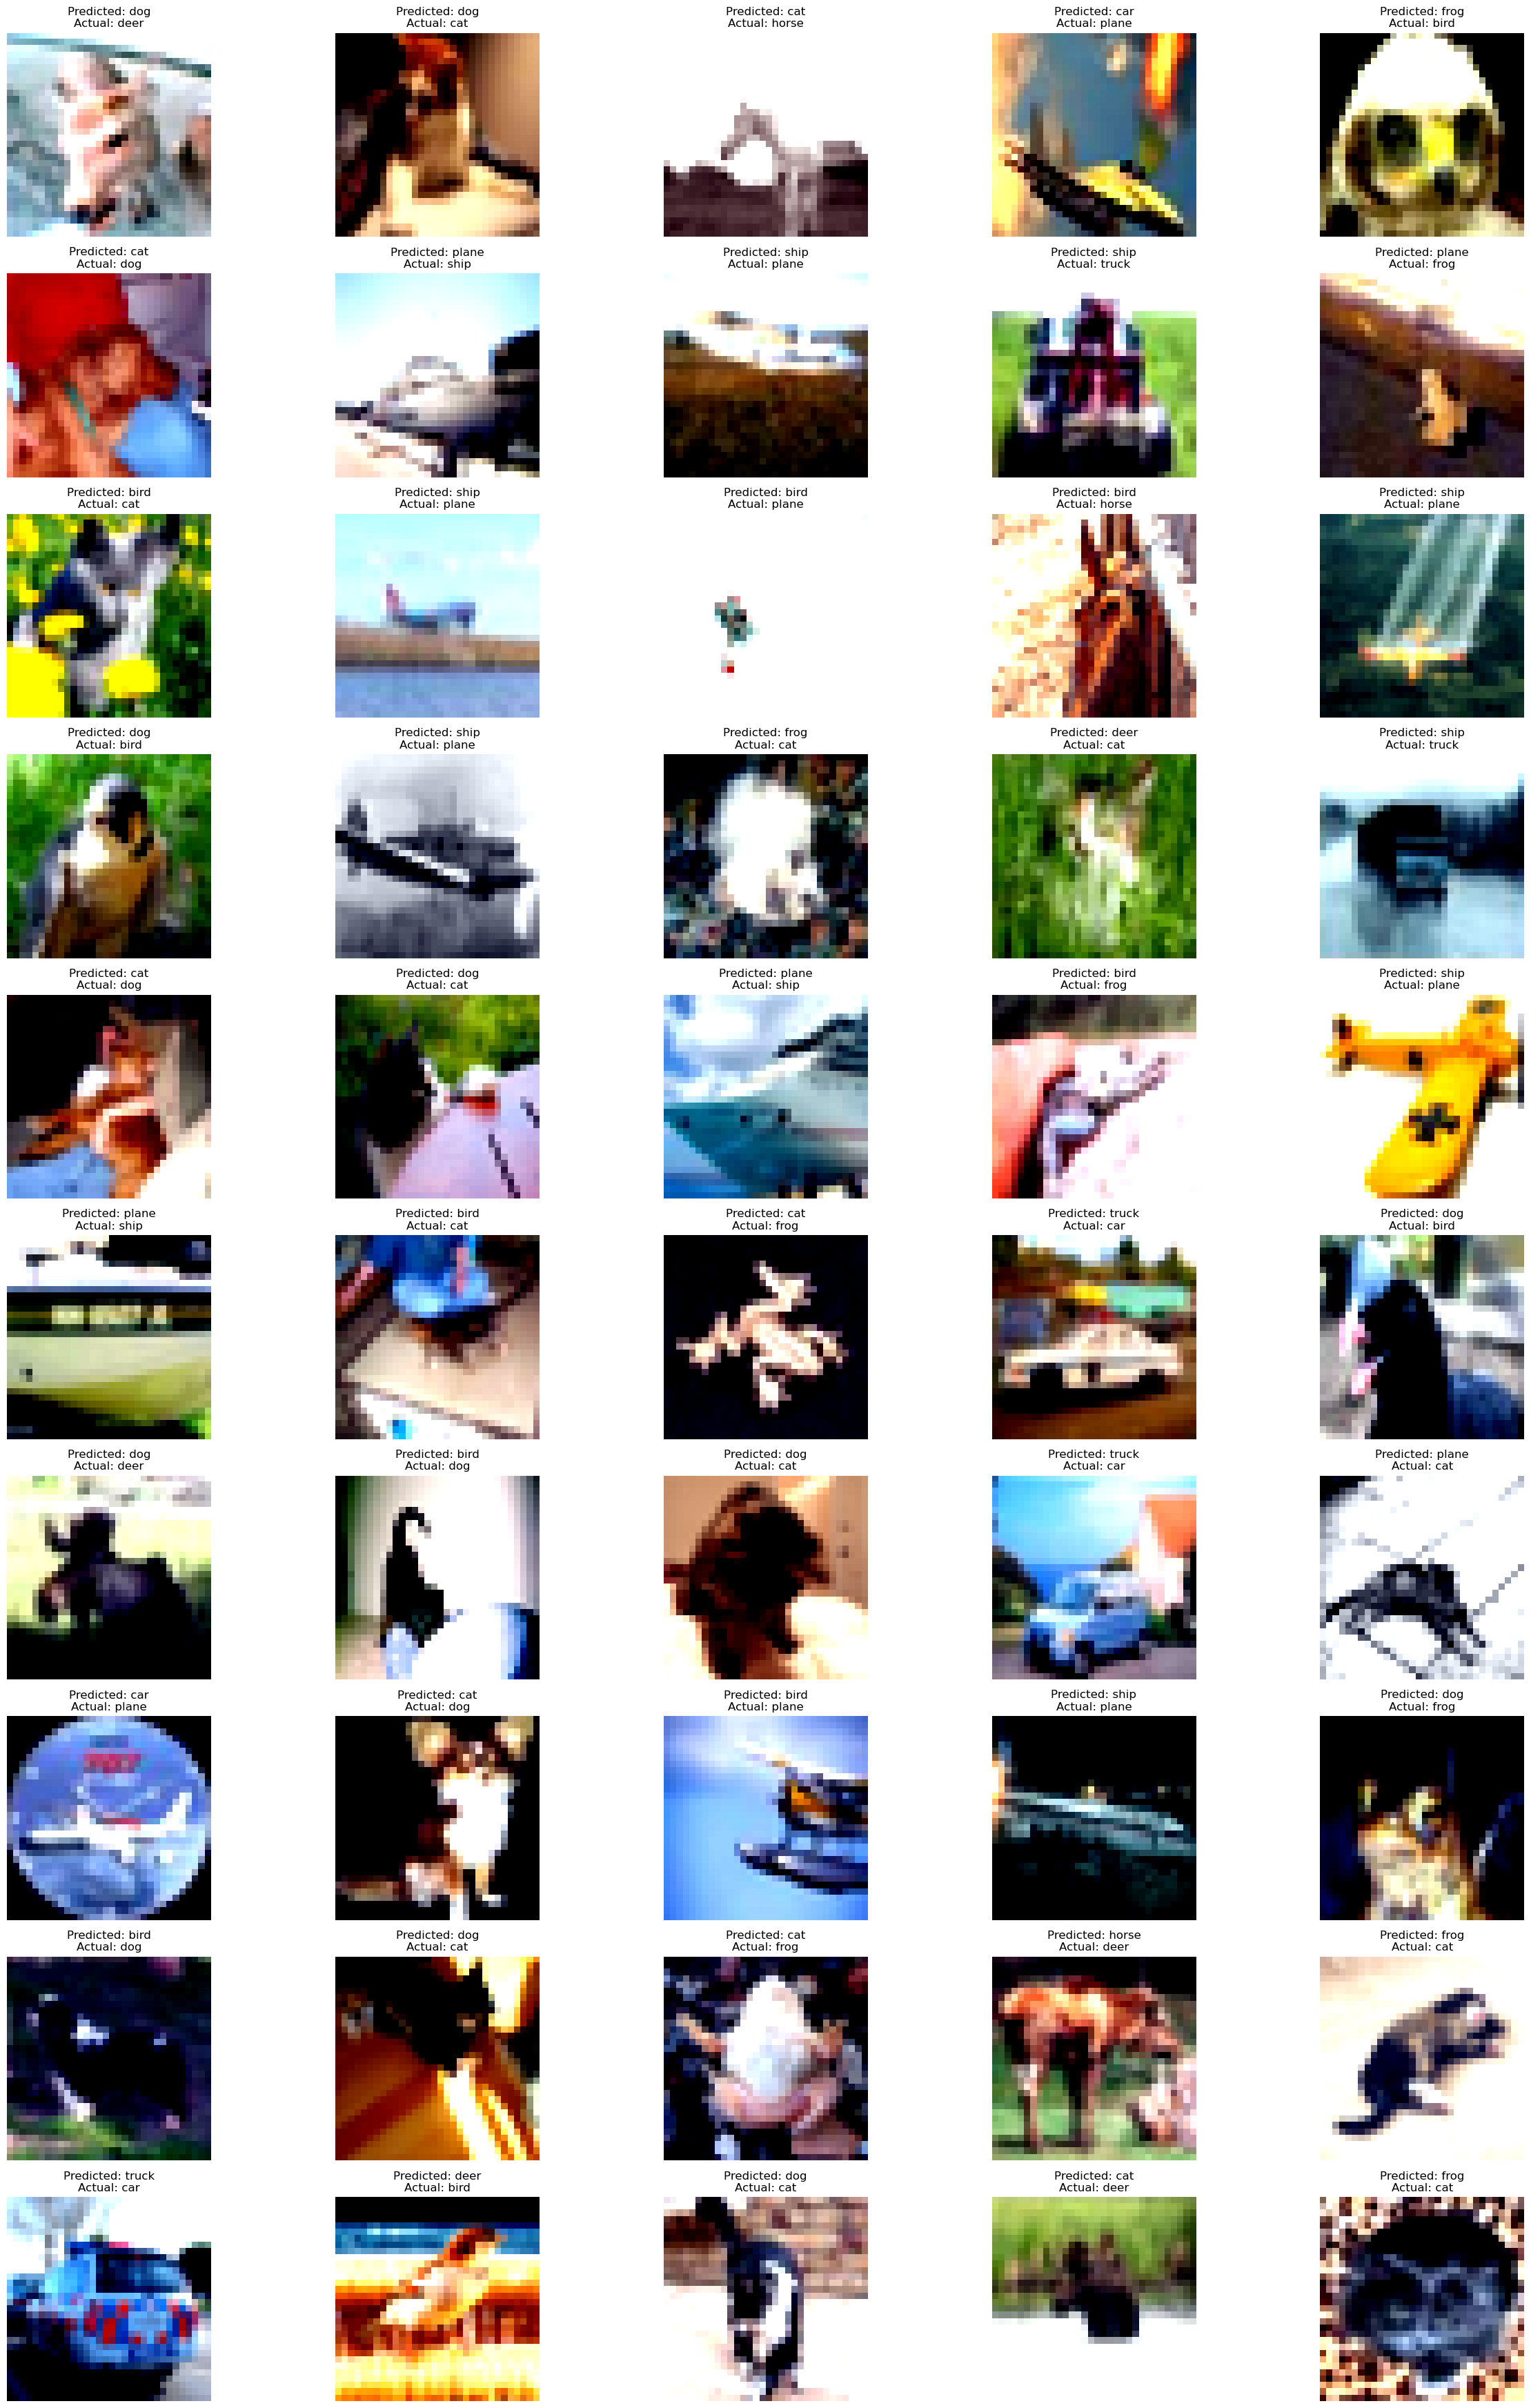

In [68]:
# import matplotlib.pyplot as plt
%matplotlib inline

def plot_misclassified_images(model, device, testloader, classes):
    model = model.to(device)
    model.eval()  
    misclassified = []

    with torch.no_grad(): 
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred)).squeeze()
            misclassified_images = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target[misclassified_mask]

            # Store the misclassified images and their predicted/actual labels
            for image, pred, actual in zip(misclassified_images, misclassified_preds, misclassified_targets):
                misclassified.append((image, pred, actual))

            # Stop after collecting a certain number of misclassified images
            if len(misclassified) >= 500:
                break
            
        print(f"Number of misclassified images collected: {len(misclassified)}")

    # Plot the misclassified images
    fig, axes = plt.subplots(10, 5, figsize=(25, 35))
    for i, (image, pred, actual) in enumerate(misclassified[:50]):
        image = image.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        # Denormalize the image
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax = axes[i//5, i%5]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Predicted: {classes[pred.item()]}\nActual: {classes[actual.item()]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_misclassified_images(model, device, testloader, classes)

95.51% accuracy on the test set of 10000 images = aprox. 449 misclassified images

| Class Index | Class Name |
|-------------|------------|
| 0           | plane      |
| 1           | car        |
| 2           | bird       |
| 3           | cat        |
| 4           | deer       |
| 5           | dog        |
| 6           | frog       |
| 7           | horse      |
| 8           | ship       |
| 9           | truck      |

Save the first 50 misclassified samples, the same as the ones plotted.

In [ ]:
import os
import numpy as np
from PIL import Image

def save_misclassified_images(model, device, testloader, classes, save_dir='misclassified_50'):
    model = model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred)).squeeze()
            misclassified_images = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target[misclassified_mask]

            for image, pred, actual in zip(misclassified_images, misclassified_preds, misclassified_targets):
                misclassified.append((image, pred, actual))

            # Stop after collecting a certain number of misclassified images
            if len(misclassified) >= 50:
                break

    # Create the directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Save the misclassified images
    for i, (image, pred, actual) in enumerate(misclassified[:50]):
        image = image.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        
        # Denormalize the image
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        # Convert to PIL image and save
        im = Image.fromarray((image * 255).astype(np.uint8))
        im = im.resize((224, 224), Image.LANCZOS)
        im.save(os.path.join(save_dir, f'misclassified_{i}_pred_{classes[pred.item()]}_actual_{classes[actual.item()]}.png'))

# Call the function to save misclassified images
save_misclassified_images(model, device, testloader, classes, 'misclassified_50')

In [64]:
import zipfile
import os

def zip_images_and_download(image_dir, zip_filename):
    # Create a zip file
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    zipf.write(os.path.join(root, file), file)
    
    # Move the zip file to a location that can be downloaded from JupyterHub
    os.replace(zip_filename, f"SimpleNet_Pytorch/cifar/{zip_filename}")

    # Provide a link to download the zip file
    return f"/mnt/data/{zip_filename}"

# Call the function
image_directory = 'misclassified_50'  # Directory where your images are stored
zip_file_name = 'misclassified_50.zip'  # Desired name for the zip file
download_link = zip_images_and_download(image_directory, zip_file_name)

# This will print out the link that you can use to download the file
print(download_link)

FileNotFoundError: [Errno 2] No such file or directory: 'misclassified_50.zip' -> 'SimpleNet_Pytorch/cifar/misclassified_50.zip'

Save all misclassified images

In [58]:
from pathlib import Path
from PIL import Image
def save_misclassified_samples(model, device, testloader, save_dir):
    model = model.to(device)  # Move the model to the desired device
    model.eval()  
    misclassified_samples = []

    with torch.no_grad():  
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred)).squeeze()
            misclassified_data = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target[misclassified_mask]

            for img, pred, actual in zip(misclassified_data, misclassified_preds, misclassified_targets):
                misclassified_samples.append((img, pred, actual))
                
    # Define mean and std for denormalization if the dataset was normalized
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)  # Move mean tensor to the desired device
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)  # Move std tensor to the desired device
    # Save the misclassified images to the set path
    if misclassified_samples:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        for i, (img, pred, actual) in enumerate(misclassified_samples):
            # Denormalize
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            # Convert to PIL image
            img = transforms.ToPILImage()(img.squeeze().cpu())  # Move img tensor to CPU before converting to PIL image
            # Convert grayscale image to RGB with a single channel
            # img = img.convert('RGB')  
            img = img.resize((128, 128), Image.LANCZOS)
            # Save 
            img.save(save_dir / f'misclassified_{i}_pred_{classes[pred.item()]}_actual_{classes[actual.item()]}.png')
    else:
        return None
save_misclassified_samples(model.to(device), device, testloader, 'misclassified_all')